In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from collections import Counter

train_path = '/content/drive/My Drive/big-data-analytics-2025/train.csv'
test_path = '/content/drive/My Drive/big-data-analytics-2025/test_without_labels.csv'

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

#Initial Analysis

In [ ]:
print(train_df.head())

       Id                                              Title  \
0  227464  Netflix is coming to cable boxes, and Amazon i...   
1  244074  Pharrell, Iranian President React to Tehran 'H...   
2   60707                    Wildlife service seeks comments   
3   27883  Facebook teams up with Storyful to launch 'FB ...   
4  169596           Caesars plans US$880 mln New York casino   

                                             Content          Label  
0   if you subscribe to one of three rinky-dink (...  Entertainment  
1   pharrell, iranian president react to tehran '...  Entertainment  
2   the u.s. fish and wildlife service has reopen...     Technology  
3   the very nature of social media means it is o...     Technology  
4   caesars plans us$880 mln new york casino jul ...       Business  


In [ ]:
category_proportions= train_df['Label'].value_counts(normalize=True)

In [ ]:
print(category_proportions)

Label
Entertainment    0.401038
Technology       0.269305
Business         0.222139
Health           0.107518
Name: proportion, dtype: float64


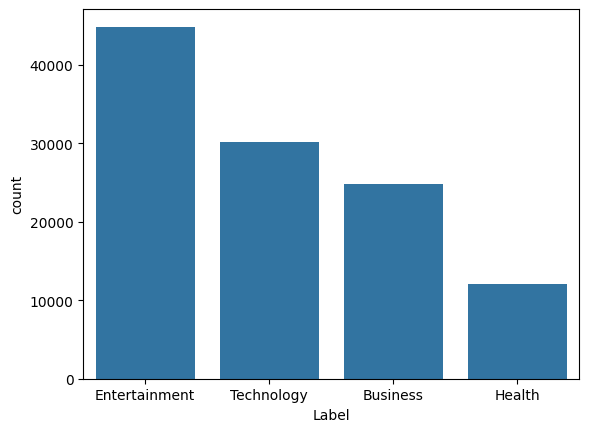

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Label', data=train_df)
plt.show()

In [ ]:
# Analyze text length distributions
train_df['title_length'] = train_df['Title'].str.len()
train_df['content_length'] = train_df['Content'].str.len()

# Summary statistics
basic_stats = pd.DataFrame({
    'Title Length': [
        train_df['title_length'].count(),
        train_df['title_length'].mean(),
        train_df['title_length'].min(),
        train_df['title_length'].max()
    ],
    'Content Length': [
        train_df['content_length'].count(),
        train_df['content_length'].mean(),
        train_df['content_length'].min(),
        train_df['content_length'].max()
    ]
}, index=['Count', 'Mean', 'Min', 'Max']).round(2)

print("\nBasic Text Length Statistics:")
print(basic_stats)

# Average lengths by category
print("\nAverage lengths by category:")
category_stats = train_df.groupby('Label').agg({
    'title_length': ['mean'],
    'content_length': ['mean']
}).round(2)
print(category_stats)


Basic Text Length Statistics:
       Title Length  Content Length
Count     111795.00       111795.00
Mean          59.22         2539.79
Min            5.00           16.00
Max        24929.00        78614.00

Average lengths by category:
              title_length content_length
                      mean           mean
Label                                    
Business             55.84        2816.13
Entertainment        61.51        2328.11
Health               56.89        2683.91
Technology           59.55        2569.54


In [ ]:
word_counts = train_df['Content'].apply(lambda text: Counter(text.lower().split()))

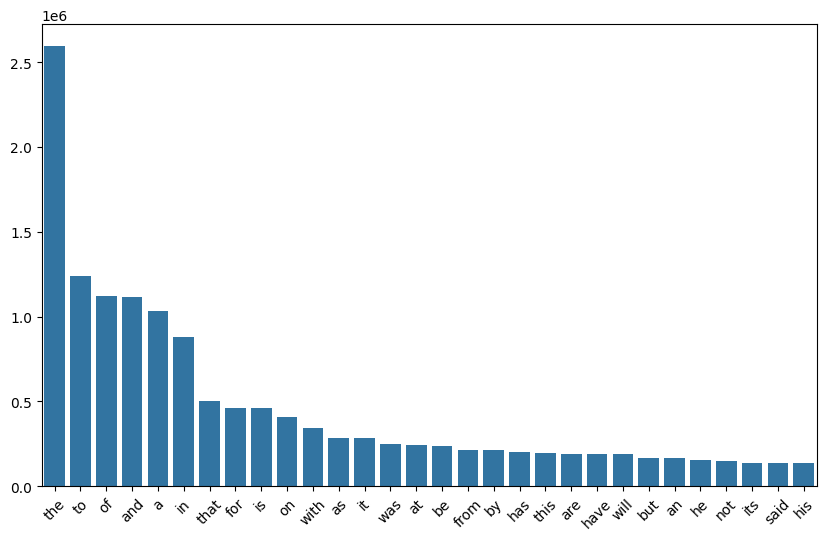

In [ ]:
all_word_counts = Counter()
for word_count in word_counts:
    all_word_counts.update(word_count)
most_common_words = all_word_counts.most_common(30)
words,freqs = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(freqs))
plt.xticks(rotation=45)
plt.show()

In [ ]:
train_df.isnull().sum()

,0
Id,0
Title,0
Content,0
Label,0


In [ ]:
test_df.isnull().sum()

,0
Id,0
Title,0
Content,0


#Data preprocessing

In [ ]:
import nltk
import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'([.,!?()])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token)
             for token in tokens
             if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [ ]:
train_titles = train_df['Title'].apply(process_text)
train_content = train_df['Content'].apply(process_text)
test_titles = test_df['Title'].apply(process_text)
test_content = test_df['Content'].apply(process_text)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2


train_text = train_titles + " " + train_content
test_text = test_titles + " " + test_content

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Label'])

vectorizer = CountVectorizer(binary=True)
train_vectors = vectorizer.fit_transform(train_text)
test_vectors = vectorizer.transform(test_text)

selector = SelectKBest(chi2, k=5000)
final_features = selector.fit_transform(train_vectors, y)
test_final_features = selector.transform(test_vectors)

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
scoring = {
    'accuracy': 'accuracy',
    'precision_micro': make_scorer(precision_score, average='micro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_micro': make_scorer(recall_score, average='micro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

#Support Vector Machines

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

param_grid = {
    'sgdclassifier__alpha': [0.01, 0.05, 0.1],
    'sgdclassifier__loss': ['hinge'],  # keep hinge for SVM
    'sgdclassifier__max_iter': [ 150, 200],
    'sgdclassifier__tol': [1e-3, 6e-4, 1e-4, 6e-5],
    'sgdclassifier__learning_rate': ['optimal']
}

# Create pipeline
sgd_pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    SGDClassifier(random_state=42, class_weight='balanced')
)


stratified_kfold = StratifiedKFold(n_splits=5)
svm_grid_search = GridSearchCV(
    sgd_pipeline,
    param_grid,
    cv=stratified_kfold,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    refit='accuracy'
)

# Fit grid search
svm_grid_search.fit(final_features, y)
print("Best parameters:", svm_grid_search.best_params_)
print("\nBest model scores:")
for metric in scoring.keys():
    print(f"Mean {metric.replace('_', ' ').title()}: {svm_grid_search.cv_results_[f'mean_test_{metric}'][svm_grid_search.best_index_]:.3f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'sgdclassifier__alpha': 0.05, 'sgdclassifier__learning_rate': 'optimal', 'sgdclassifier__loss': 'hinge', 'sgdclassifier__max_iter': 150, 'sgdclassifier__tol': 0.0001}

Best model scores:
Mean Accuracy: 0.949
Mean Precision Micro: 0.949
Mean Precision Macro: 0.945
Mean Precision Weighted: 0.949
Mean Recall Micro: 0.949
Mean Recall Macro: 0.946
Mean Recall Weighted: 0.949
Mean F1 Micro: 0.949
Mean F1 Macro: 0.945
Mean F1 Weighted: 0.949


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

# Get cross-validated predictions using the best model
y_pred = cross_val_predict(svm_grid_search.best_estimator_, final_features, y, cv=stratified_kfold)
target_names = ['Entertainment', 'Technology', 'Business', 'Health']
print("\nDetailed Classification Report across all folds:")
print(classification_report(y, y_pred,target_names=target_names))


Detailed Classification Report across all folds:
               precision    recall  f1-score   support

Entertainment       0.92      0.91      0.92     24834
   Technology       0.98      0.98      0.98     44834
     Business       0.95      0.96      0.96     12020
       Health       0.93      0.94      0.93     30107

     accuracy                           0.95    111795
    macro avg       0.95      0.95      0.95    111795
 weighted avg       0.95      0.95      0.95    111795



#Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [35],
    'randomforestclassifier__class_weight': ['balanced']
}

# Create pipeline
rf_pipeline = make_pipeline(
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=stratified_kfold,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    refit='accuracy'
)

grid_search_rf.fit(final_features, y)

print("Best parameters:", grid_search_rf.best_params_)
print("\nBest model scores:")
for metric in scoring.keys():
    print(f"Mean {metric.replace('_', ' ').title()}: {grid_search_rf.cv_results_[f'mean_test_{metric}'][grid_search_rf.best_index_]:.3f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 35, 'randomforestclassifier__n_estimators': 200}

Best model scores:
Mean Accuracy: 0.926
Mean Precision Micro: 0.926
Mean Precision Macro: 0.923
Mean Precision Weighted: 0.925
Mean Recall Micro: 0.926
Mean Recall Macro: 0.919
Mean Recall Weighted: 0.926
Mean F1 Micro: 0.926
Mean F1 Macro: 0.921
Mean F1 Weighted: 0.925


In [ ]:
y_pred_rf = cross_val_predict(grid_search_rf.best_estimator_, final_features, y, cv=stratified_kfold)

print("\nDetailed Classification Report across all folds:")
print(classification_report(y, y_pred_rf,target_names=target_names))


Detailed Classification Report across all folds:
               precision    recall  f1-score   support

Entertainment       0.90      0.88      0.89     24834
   Technology       0.94      0.97      0.96     44834
     Business       0.93      0.93      0.93     12020
       Health       0.91      0.90      0.91     30107

     accuracy                           0.93    111795
    macro avg       0.92      0.92      0.92    111795
 weighted avg       0.93      0.93      0.93    111795



#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline

final_features_bool = final_features.astype(bool)
test_final_features_bool = test_final_features.astype(bool)

final_knn_pipeline = make_pipeline(
    KNeighborsClassifier(
        n_neighbors=7,
        metric='jaccard',
        n_jobs=-1
    )
)

stratified_kfold = StratifiedKFold(n_splits=5)

cv_scores_knn = cross_validate(
    final_knn_pipeline,
    final_features_bool.toarray(),
    y,
    cv=stratified_kfold,
    scoring=scoring,
    n_jobs=-1
)

print("\nCross-validation scores on full dataset:")
for metric in scoring.keys():
    print(f"Mean {metric.replace('_', ' ').title()}: {cv_scores_knn[f'test_{metric}'].mean():.3f}")

y_pred_knn = cross_val_predict(final_knn_pipeline, final_features_bool.toarray(), y, cv=stratified_kfold)

print("\nDetailed Classification Report across all folds:")
print(classification_report(y, y_pred_knn,target_names=target_names))


Cross-validation scores on full dataset:
Mean Accuracy: 0.963
Mean Precision Micro: 0.963
Mean Precision Macro: 0.962
Mean Precision Weighted: 0.963
Mean Recall Micro: 0.963
Mean Recall Macro: 0.958
Mean Recall Weighted: 0.963
Mean F1 Micro: 0.963
Mean F1 Macro: 0.960
Mean F1 Weighted: 0.963

Detailed Classification Report across all folds:
               precision    recall  f1-score   support

Entertainment       0.93      0.94      0.94     24834
   Technology       0.98      0.99      0.98     44834
     Business       0.98      0.95      0.96     12020
       Health       0.96      0.95      0.95     30107

     accuracy                           0.96    111795
    macro avg       0.96      0.96      0.96    111795
 weighted avg       0.96      0.96      0.96    111795



#Predict labels in test set using the best model

In [ ]:
svm_accuracy = svm_grid_search.cv_results_['mean_test_accuracy'][svm_grid_search.best_index_]
rf_accuracy = grid_search_rf.cv_results_['mean_test_accuracy'][grid_search_rf.best_index_]
knn_accuracy = cv_scores_knn['test_accuracy'].mean()

accuracies = {
    'SVM': svm_accuracy,
    'Random Forest': rf_accuracy,
    'KNN': knn_accuracy
}

best_model_name = max(accuracies, key=accuracies.get)
print(f"\nBest model is {best_model_name} with accuracy: {accuracies[best_model_name]:.3f}")


if best_model_name == 'SVM':
    test_predictions = svm_grid_search.predict(test_final_features)
elif best_model_name == 'Random Forest':
    test_predictions = grid_search_rf.predict(test_final_features)
else:  # KNN
    # Fit the KNN pipeline with best parameters on full training data
    final_knn_pipeline.fit(final_features_bool.toarray(), y)
    test_predictions = final_knn_pipeline.predict(test_final_features_bool.toarray())

predicted_labels = label_encoder.inverse_transform(test_predictions)

output_df = pd.DataFrame({
    'Id': test_df['Id'],
    'Predicted': predicted_labels
})

output_df.to_csv('testSet_categories.csv', index=False)

print("\nPredictions have been saved to 'testSet_categories.csv'")


Best model is KNN with accuracy: 0.963

Predictions have been saved to 'testSet_categories.csv'


In [ ]:
output_df.to_csv('/content/drive/My Drive/testSet_categories.csv', index=False)